In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import re
from urllib.parse import urlparse
from collections import Counter


In [3]:
file_path = 'dataset1.csv'
df = pd.read_csv(file_path)

df.head()

                                                 url  class
0                    freebase.com/view/en/bob_sirois      0
1                     en.wikipedia.org/wiki/Joie_Lee      0
2           pipl.com/directory/people/Rejean/Beaudin      0
3  flickr.com/photos/teneyck/sets/72157610336209297/      0
4  ussoccer.com/News/Federation-Services/2009/06/...      0
Number of columns: 2
Column 'url': 0 zeros, 0 ones
Column 'class': 42058 zeros, 9271 ones


In [3]:
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum(count / lns * np.log2(count / lns) for count in p.values())

def extract_features(url):
    features = {}

    # URL Length
    features['url_length'] = len(url)

    # Number of Dots
    features['num_dots'] = url.count('.')

    # Number of Hyphens
    features['num_hyphens'] = url.count('-')

    # Number of Digits
    features['num_digits'] = sum(c.isdigit() for c in url)

    # Presence of IP Address
    features['presence_of_ip'] = int(bool(re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', url)))

    # Number of Subdomains
    parsed_url = urlparse(url)
    subdomain = parsed_url.hostname.split('.')[:-2] if parsed_url.hostname else []
    features['num_subdomains'] = len(subdomain)

    # Presence of Suspicious Words
    suspicious_words = ['login', 'update', 'free', 'security', 'webscr', 'ebayisapi', 'signin']
    features['presence_of_suspicious_words'] = int(any(word in url for word in suspicious_words))

    # Number of Parameters
    features['num_parameters'] = len(parsed_url.query.split('&')) if parsed_url.query else 0

    # Presence of HTTPS
    features['presence_of_https'] = int(parsed_url.scheme == 'https')

    # Length of Query String
    features['length_of_query_string'] = len(parsed_url.query)

    # Presence of Encoded Characters
    features['presence_of_encoded_characters'] = int('%' in url)

    # Presence of Suspicious TLDs
    suspicious_tlds = ['.xyz', '.top', '.info', '.loan', '.club']
    features['presence_of_suspicious_tlds'] = int(any(url.endswith(tld) for tld in suspicious_tlds))

    # Presence of Brand Names (example list, needs customization based on use case)
    brand_names = ['apple', 'google', 'paypal', 'microsoft', 'amazon']
    features['presence_of_brand_names'] = int(any(brand in url for brand in brand_names))

    # Length of Domain Name
    domain = parsed_url.hostname
    features['length_of_domain_name'] = len(domain) if domain else 0

    # Number of Directory Levels
    features['num_directory_levels'] = url.count('/')

    # Ratio of Digits to Characters
    total_chars = len(url)
    num_digits = features['num_digits']
    features['ratio_digits_to_chars'] = num_digits / total_chars if total_chars > 0 else 0

    # Presence of Non-ASCII Characters
    features['presence_of_non_ascii'] = int(any(ord(c) > 127 for c in url))

    # Presence of @ Symbol
    features['presence_of_at_symbol'] = int('@' in url)

    # Presence of Redirection (//)
    features['presence_of_redirection'] = int('//' in url[8:])  # Ignore 'http://' or 'https://'

    # URL Entropy
    features['url_entropy'] = entropy(url)

    return features

In [4]:
features = df['url'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Add the target label to the features dataframe
features_df['label'] = df['class']

In [5]:
X = features_df.drop('label', axis=1)
y = features_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}



In [7]:
results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'classification_report': report,
        'confusion_matrix': cm
    }

# Print results
print(results)

C:\Users\Suman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7421, number of negative: 33642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 41063, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180722 -> initscore=-1.511461
[LightGBM] [Info] Start training from score -1.511461
{'Random Forest': {'accuracy': 0.8798947983635301, 'f1_score': 0.8733718623748149, 'classification_report': {'0': {'precision': 0.905681689822659, 'recall': 0.9527091254752852, 'f1-score': 0.9286003821877352, 'support': 8416.0}, '1': {'precision': 0.7183297947629158, 'recall': 0.5486486486486486, 'f1-score': 0.6221268771069568, 'support': 1850.0}, 'accuracy': 0.8798947983635301, 'macro avg': {'precision': 0.8120057422927873, 'recall': 0.75

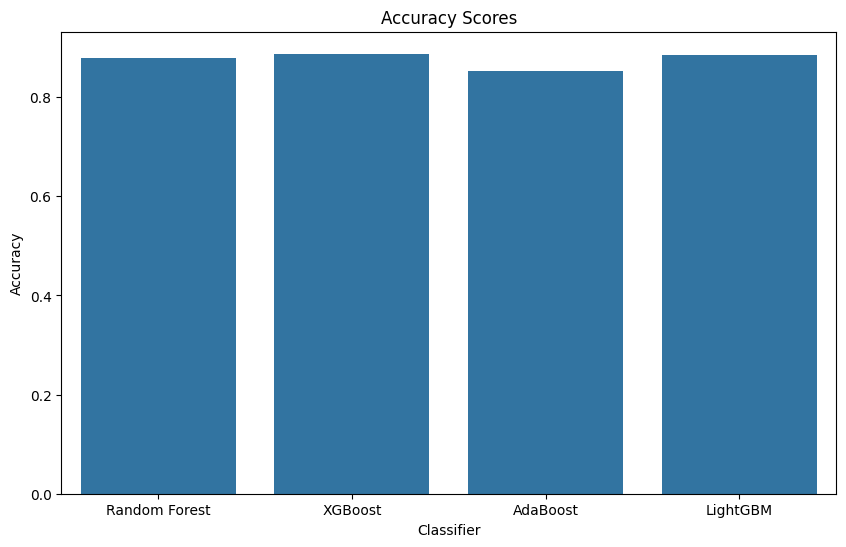

In [8]:
accuracies = [results[clf]['accuracy'] for clf in classifiers]
plt.figure(figsize=(10, 6))
sns.barplot(x=list(classifiers.keys()), y=accuracies)
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.show()

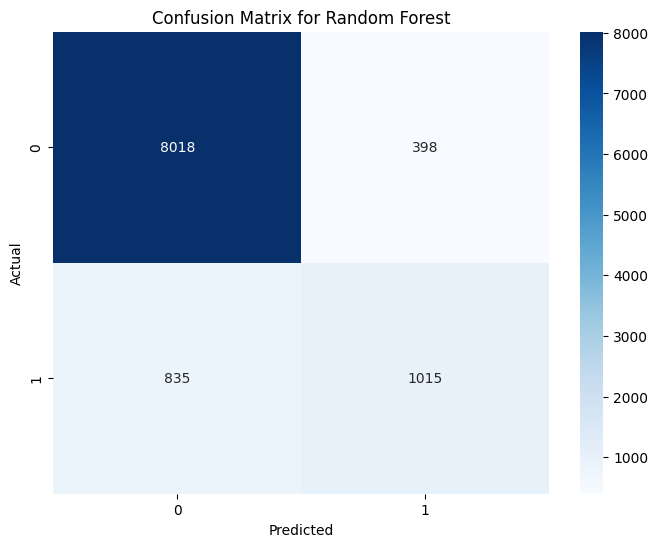

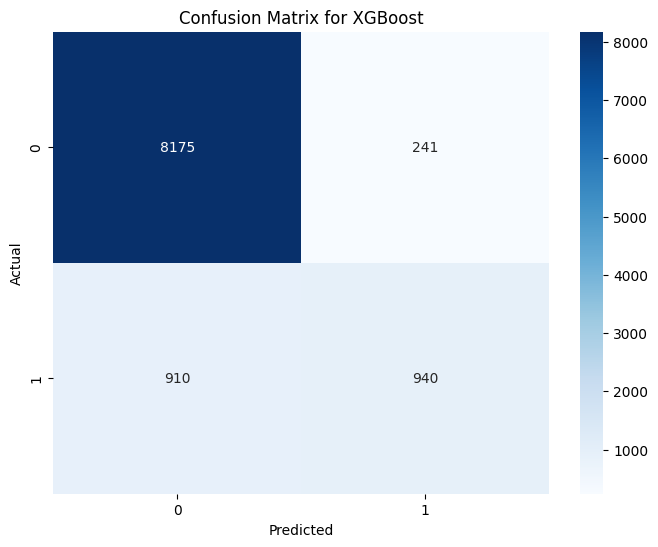

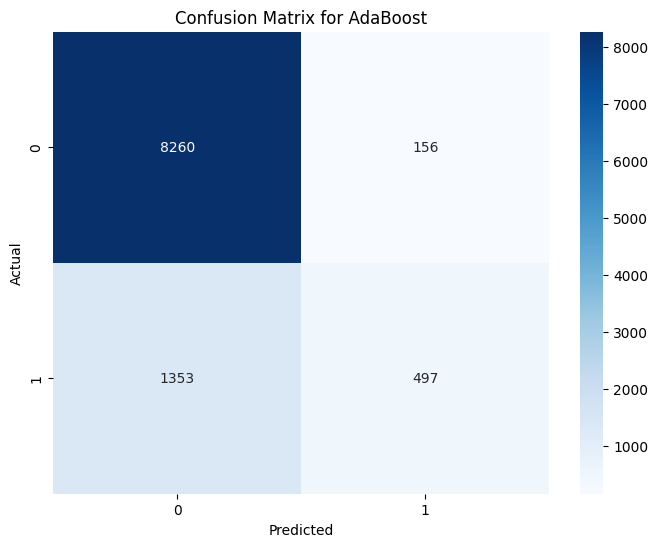

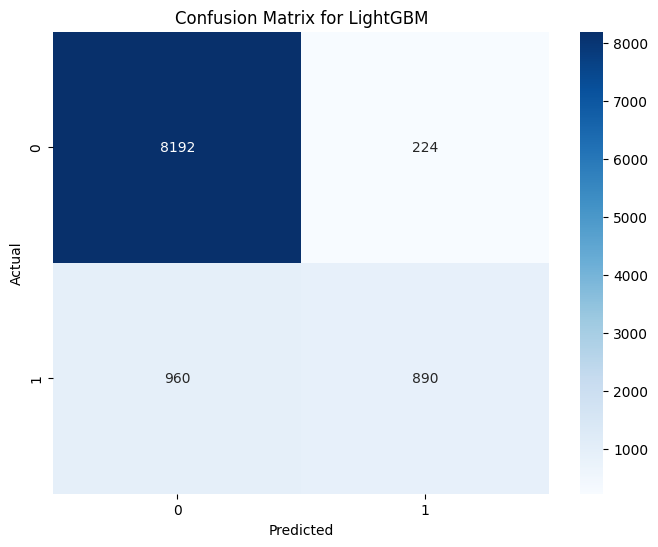

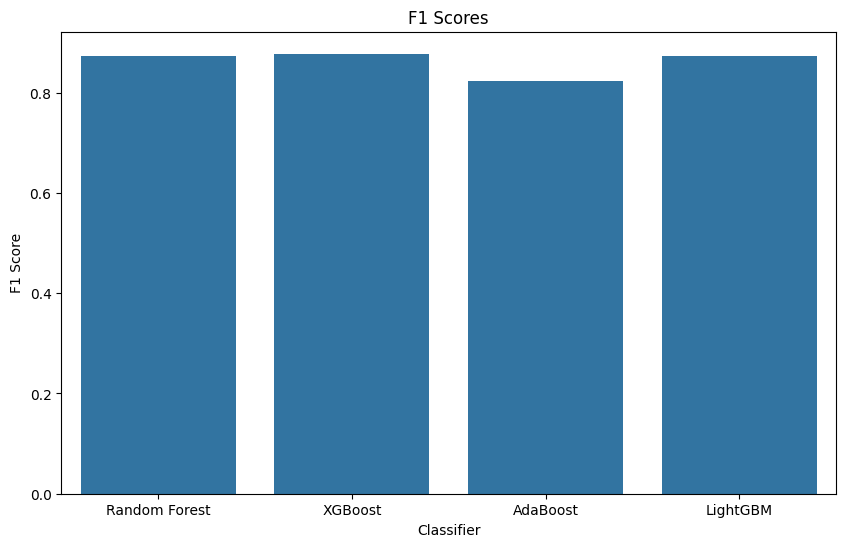

In [14]:
for name, result in results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

f1_scores = [results[clf]['f1_score'] for clf in classifiers]
plt.figure(figsize=(10, 6))
sns.barplot(x=list(classifiers.keys()), y=f1_scores)
plt.title('F1 Scores')
plt.ylabel('F1 Score')
plt.xlabel('Classifier')
plt.show()

In [15]:
for name, result in results.items():
    print(f"Classification Report for {name}")
    print(pd.DataFrame(result['classification_report']).transpose())

# Save models
import joblib
for name, model in classifiers.items():
    joblib.dump(model, f'{name}_model.pkl')


Classification Report for Random Forest
              precision    recall  f1-score       support
0              0.905682  0.952709  0.928600   8416.000000
1              0.718330  0.548649  0.622127   1850.000000
accuracy       0.879895  0.879895  0.879895      0.879895
macro avg      0.812006  0.750679  0.775364  10266.000000
weighted avg   0.871920  0.879895  0.873372  10266.000000
Classification Report for XGBoost
              precision    recall  f1-score       support
0              0.899835  0.971364  0.934232   8416.000000
1              0.795936  0.508108  0.620257   1850.000000
accuracy       0.887882  0.887882  0.887882      0.887882
macro avg      0.847885  0.739736  0.777245  10266.000000
weighted avg   0.881112  0.887882  0.877652  10266.000000
Classification Report for AdaBoost
              precision    recall  f1-score      support
0              0.859253  0.981464  0.916302   8416.00000
1              0.761103  0.268649  0.397123   1850.00000
accuracy       0.853010 

In [11]:
def test_new_urls(model, new_urls):
    new_features = []
    for url in new_urls:  # Iterate over each URL
        # Extract features for each URL individually
        new_features.append(extract_features(url))
    # Create a DataFrame from the extracted features
    new_features_df = pd.DataFrame(new_features)
    predictions = model.predict(new_features_df)  # Predict using the DataFrame
    return predictions

# Example new URLs for testing
new_urls = ["http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZ..."]
model_name = 'XGBoost'  # Example model
model = classifiers[model_name]

predictions = test_new_urls(model, new_urls)
print(f"Predictions: {predictions}")

Predictions: [1]


In [12]:
models = {}
for name in classifiers.keys():
    models[name] = joblib.load(f'{name}_model.pkl')

# Now you can use the models as needed, for example:
# predictions = models['model_name'].predict(data)